In [32]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, Dropout, MaxPooling2D
from sklearn.model_selection import train_test_split
import os
import cv2
import matplotlib.pyplot as plt

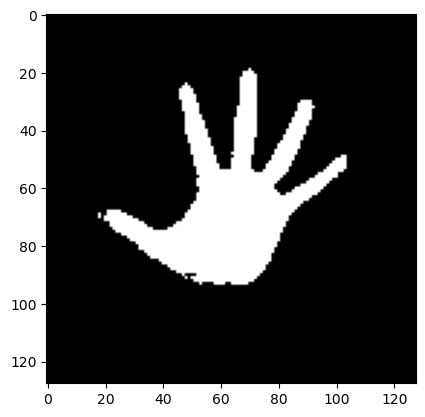

In [33]:
img_path = 'Ex_Files_Computer_Vision_Deep_Dive_in_Python/fingers/test/000e7aa6-100b-4c6b-9ff0-e7a8e53e4465_5L.png'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

_, img_thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

plt.imshow(img_thresh, cmap='gray')

In [70]:
path = 'Ex_Files_Computer_Vision_Deep_Dive_in_Python/fingers/'
folders = ['train','test']
classes = ['0','1','2','3','4','5']

images = []
labels = []

for folder in folders:
    folder_dir = os.path.join(path,folder)
    for file in os.listdir(folder_dir):
        img_path = os.path.join(folder_dir,file)
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        ## no need to resize, all 128x128
        
        img_thresh = np.expand_dims(img, axis=-1)
        
        label = int(file.split('_')[-1][0])
        
        images.append(img_thresh)
        labels.append(label)
        

images = np.array(images)
labels = np.array(labels)
    
images.shape

(21600, 128, 128, 1)

In [71]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 42, shuffle=True)

print(x_train.shape)
print(x_test.shape)

(17280, 128, 128, 1)
(4320, 128, 128, 1)


In [88]:
## Data Augmentation time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

train_data_augmentation = ImageDataGenerator(rescale = 1/255,rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_data_augmentation = ImageDataGenerator(rescale = 1/255)

train_gen = train_data_augmentation.flow(x_train,y_train,batch_size = 32, shuffle=True)
test_gen = test_data_augmentation.flow(x_test,y_test,batch_size = 32)

In [94]:
## model building
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'relu', input_shape = (128,128,1)))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())

model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(.50))
model.add(Dense(6,activation = 'softmax'))

## Optimizer and Early Stop
optimizer = Adam(learning_rate=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,278 (6.34 MB)

 Trainable params: 1,662,278 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [95]:
history = model.fit(train_gen, validation_data=test_gen, epochs=10, callbacks=[early_stop])

Epoch 1/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 209s 380ms/step - accuracy: 0.6625 - loss: 0.8346 - val_accuracy: 0.9988 - val_loss: 0.0237
Epoch 2/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 260s 377ms/step - accuracy: 0.9501 - loss: 0.1351 - val_accuracy: 0.9986 - val_loss: 0.0045
Epoch 3/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 208s 385ms/step - accuracy: 0.9697 - loss: 0.0900 - val_accuracy: 0.9991 - val_loss: 0.0033
Epoch 4/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 206s 381ms/step - accuracy: 0.9733 - loss: 0.0745 - val_accuracy: 0.9998 - val_loss: 8.3014e-04
Epoch 5/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 205s 378ms/step - accuracy: 0.9764 - loss: 0.0608 - val_accuracy: 0.9984 - val_loss: 0.0055
Epoch 6/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 207s 381ms/step - accuracy: 0.9800 - loss: 0.0543 - val_accuracy: 0.9995 - val_loss: 0.0015
Epoch 7/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 204s 378ms/step - accuracy: 0.9846 - loss: 0.0396 - val_accuracy: 0.9984 - val_loss: 0.0095


In [96]:
_, train_acc = model.evaluate(x_train,y_train)
print(train_acc)

540/540 ━━━━━━━━━━━━━━━━━━━━ 59s 108ms/step - accuracy: 0.9416 - loss: 18.8445
0.9372684955596924


In [97]:
_, test_acc = model.evaluate(x_test,y_test)
print(test_acc)

135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.9356 - loss: 17.8565
0.9400463104248047


In [149]:
target_size = 128

def resize_with_aspect_ratio(image, target_size):
    # Get original dimensions
    original_height, original_width = image.shape[:2]
    
    # Calculate the aspect ratio
    aspect_ratio = original_width / original_height
    
    # Calculate new dimensions based on the target size
    if original_width > original_height:
        new_width = target_size
        new_height = int(target_size / aspect_ratio)
    else:
        new_height = target_size
        new_width = int(target_size * aspect_ratio)
    
    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height))

    # Create a new image with the target size, filled with black (or any other color)
    padded_image = np.zeros((target_size, target_size), dtype=np.uint8)

    # Calculate padding
    x_offset = (target_size - new_width) // 2
    y_offset = (target_size - new_height) // 2

    # Place the resized image in the middle of the padded image
    padded_image[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = resized_image
    
    return padded_image

def preprocess_image(img_path, target_size=128):
    # Read the image in grayscale mode
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # calculate the mean intensity
    mean_intensity = np.mean(img)

    #invert image based off of background
    if mean_intensity > 127:
        img = cv2.bitwise_not(img)

    # gaussian blur
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # adaptive thresholding 
    _, img_thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # resize img
    img_thresh = resize_with_aspect_ratio(img_thresh, target_size)

    # add a channel dimension for the grayscale image
    img_thresh = np.expand_dims(img_thresh, axis=-1)

    img_thresh = img_thresh / 255.0

    # add a batch dimension since the model expects input in batches
    img_thresh = np.expand_dims(img_thresh, axis=0)

    return img_thresh


# additional func that shows img
def preprocess_img_for_show(img_path):
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    mean_intensity = np.mean(img)

    if mean_intensity > 127:
        img = cv2.bitwise_not(img)


    _, img_thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    img_thresh = resize_with_aspect_ratio(img_thresh, target_size)

 
    img_thresh = cv2.resize(img_thresh, (128, 128))
    
    mg_thresh = resize_with_aspect_ratio(img_thresh, target_size)
    
    return img_thresh

In [160]:
# testing different images

path = 'Ex_Files_Computer_Vision_Deep_Dive_in_Python/testingImages/2018-10-29-open-hand.jpg'

img = preprocess_image(path)

prediction_probabilities = model.predict(img)

predicted_fingers = np.argmax(prediction_probabilities)

print(f"The model predicts you are holding up {predicted_fingers} finger(s).")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
The model predicts you are holding up 5 finger(s).


In [161]:
path = 'Ex_Files_Computer_Vision_Deep_Dive_in_Python/testingImages/closed_fist.jpg'

img = preprocess_image(path)

prediction_probabilities = model.predict(img)

predicted_fingers = np.argmax(prediction_probabilities)

print(f"The model predicts you are holding up {predicted_fingers} finger(s).")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
The model predicts you are holding up 0 finger(s).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
The model predicts you are holding up 3 finger(s).


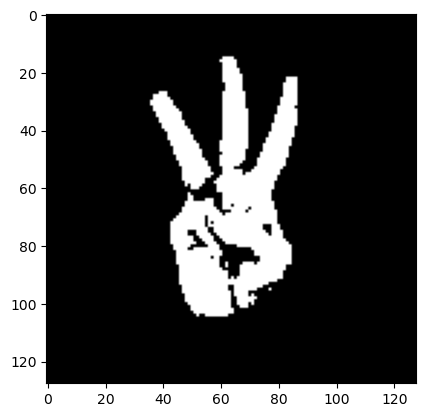

In [113]:
path = 'Ex_Files_Computer_Vision_Deep_Dive_in_Python/fingers/test/0027029b-4c3c-4785-bc1b-b8141331a108_3R.png'

img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

_, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

img = cv2.resize(img, (128, 128))

plt.imshow(img, cmap = 'gray')

img = np.expand_dims(img, axis=-1)

img = img / 255.0

img = np.expand_dims(img, axis=0)

prediction_probabilities = model.predict(img)

predicted_fingers = np.argmax(prediction_probabilities)

print(f"The model predicts you are holding up {predicted_fingers} finger(s).")

In [1]:
path = 'Ex_Files_Computer_Vision_Deep_Dive_in_Python/fingers/test/0027029b-4c3c-4785-bc1b-b8141331a108_3R.png'

img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

img = cv2.resize(img, (128, 128))

img = cv2.GaussianBlur(img, (5, 5), 0)

img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                           cv2.THRESH_BINARY, 11, 2)

plt.imshow(img, cmap = 'gray')

NameError: name 'cv2' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
The model predicts you are holding up 4 finger(s).


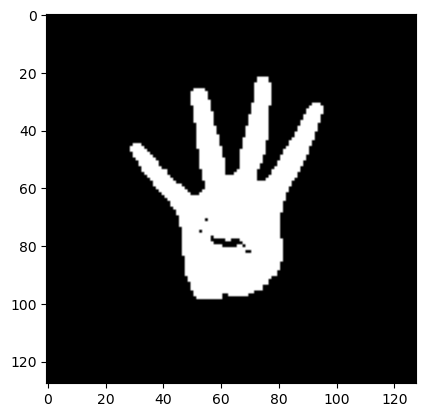

In [159]:
path = 'Ex_Files_Computer_Vision_Deep_Dive_in_Python/fingers/test/0a80ac03-5e16-4f79-8282-eba2abe1096e_4R.png'

## Ex_Files_Computer_Vision_Deep_Dive_in_Python/fingers/test/0a80ac03-5e16-4f79-8282-eba2abe1096e_4R.png

img = preprocess_image(path)

img2 = preprocess_img_for_show(path)

plt.imshow(img2, cmap = 'gray')

prediction_probabilities = model.predict(img)

predicted_fingers = np.argmax(prediction_probabilities)

print(f"The model predicts you are holding up {predicted_fingers} finger(s).")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
The model predicts you are holding up 4 finger(s).


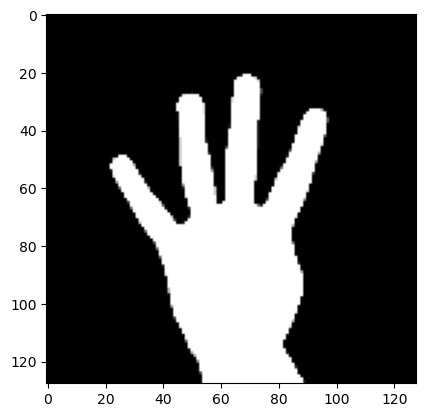

In [158]:
path = 'Ex_Files_Computer_Vision_Deep_Dive_in_Python/testingImages/istockphoto-96361039-612x612.jpg'

## Ex_Files_Computer_Vision_Deep_Dive_in_Python/fingers/test/0a80ac03-5e16-4f79-8282-eba2abe1096e_4R.png

img = preprocess_image(path)

img2 = preprocess_img_for_show(path)

plt.imshow(img2, cmap = 'gray')

prediction_probabilities = model.predict(img)

predicted_fingers = np.argmax(prediction_probabilities)

print(f"The model predicts you are holding up {predicted_fingers} finger(s).")

In [157]:
from tensorflow.keras.models import load_model


# save the entire model
model.save('CNNFingerAttempt3.h5')

# load the model back to test
loaded_model = load_model('CNNFingerAttempt3.h5')

# test the loaded model
loss, accuracy = loaded_model.evaluate(x_test, y_test)
print(f'Loaded model accuracy: {accuracy}')

135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9356 - loss: 17.8565
Loaded model accuracy: 0.9400463104248047
